In [53]:
import pandas as pd

df = pd.read_csv("Finland.csv")
df = df.iloc[:, 3:]
df.set_index("Datetime (Local)", inplace=True)

df = df.rename(columns={
    df.columns[0]: "Price"        
})

df.index = pd.to_datetime(df.index)


df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["is_night"] = df["hour"].isin([20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6]).astype(int)

df

,Price,hour,day_of_week,month,is_weekend,is_night
Datetime (Local),,,,,,
2015-01-01 02:00:00,23.37,2,3,1,0,1
2015-01-01 03:00:00,19.33,3,3,1,0,1
2015-01-01 04:00:00,17.66,4,3,1,0,1
2015-01-01 05:00:00,17.53,5,3,1,0,1
2015-01-01 06:00:00,18.07,6,3,1,0,1
...,...,...,...,...,...,...
2025-04-03 19:00:00,-2.12,19,3,4,0,0
2025-04-03 20:00:00,-2.02,20,3,4,0,1
2025-04-03 21:00:00,-2.03,21,3,4,0,1


In [34]:
import numpy as np

df_tft = df.copy()
df_tft = df_tft.reset_index()
df_tft['time_idx'] = np.arange(len(df_tft))  
df_tft['group'] = 'electricity'  
df_tft['date'] = df_tft['Datetime (Local)']



In [35]:
target_col = "Price"
time_idx_col = "time_idx"
group_id_col = "group"


In [36]:
df_tft['date'] = pd.to_datetime(df_tft['date'])
training_cutoff = df_tft["date"].max() - pd.Timedelta(days=90)


In [37]:
from pytorch_forecasting import TimeSeriesDataSet

max_encoder_length = 168  
max_prediction_length = 24  

training = TimeSeriesDataSet(
    df_tft[df_tft.date <= training_cutoff],
    time_idx=time_idx_col,
    target=target_col,
    group_ids=[group_id_col],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[group_id_col],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["Price"],
)


In [38]:
validation = TimeSeriesDataSet.from_dataset(
    training, df_tft, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True
)

train_dataloader = training.to_dataloader(train=True, batch_size=128, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=128, num_workers=2)


In [39]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from lightning.pytorch.tuner import Tuner

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 60.3k


/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_forecasting/models/base_model.py:1207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0012146256641550406
Restoring states from the checkpoint path at /Users/ethanbareille/Desktop/Perso/EdduEnergy/ElecPred/.lr_find_e916119b-f472-4a50-8b85-fb46b47c00be.ckpt
Restored all states from the checkpoint at /Users/ethanbareille/Desktop/Perso/EdduEnergy/ElecPred/.lr_find_e916119b-f472-4a50-8b85-fb46b47c00be.ckpt


suggested learning rate: 0.0012146256641550406


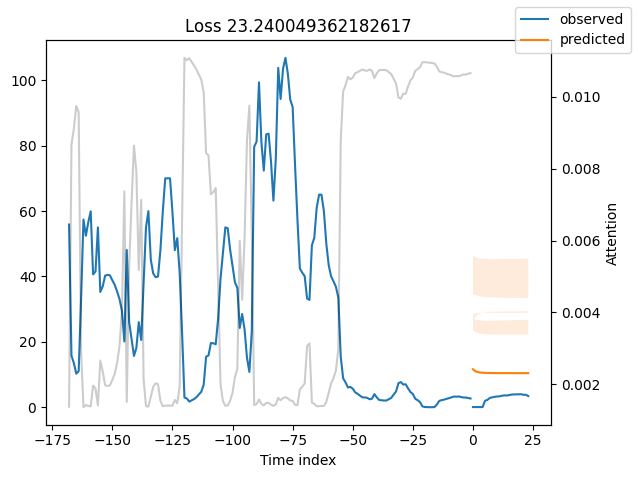

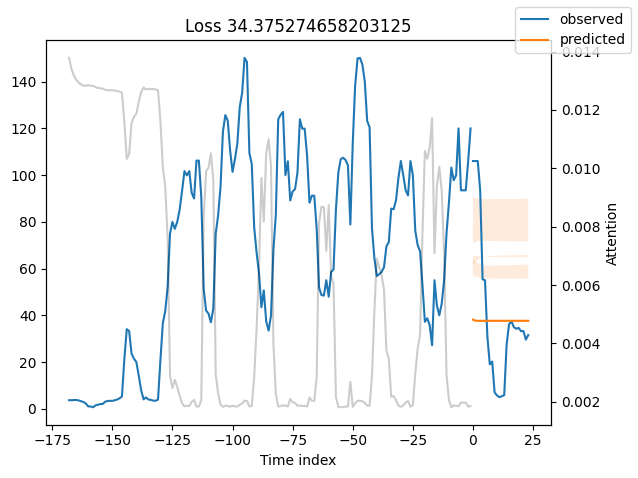

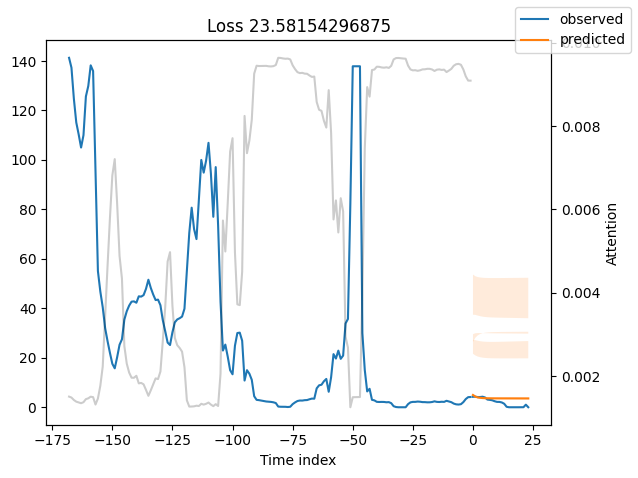

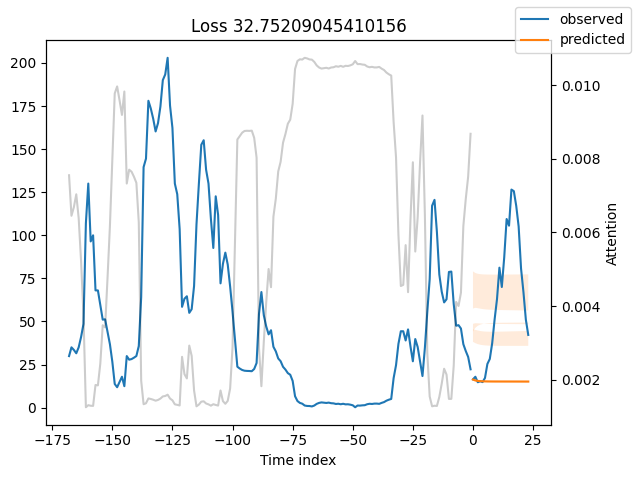

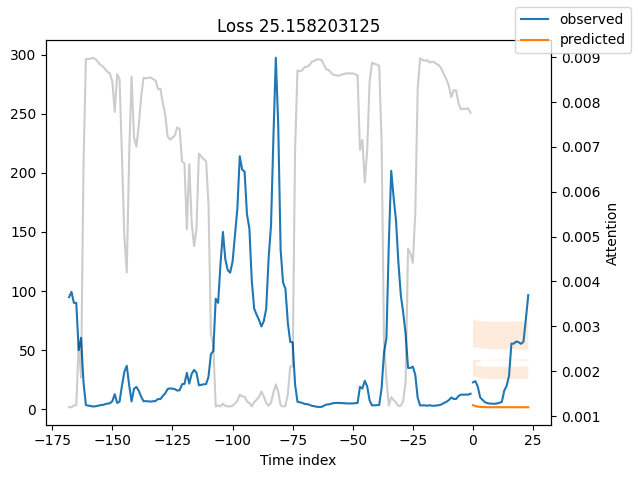

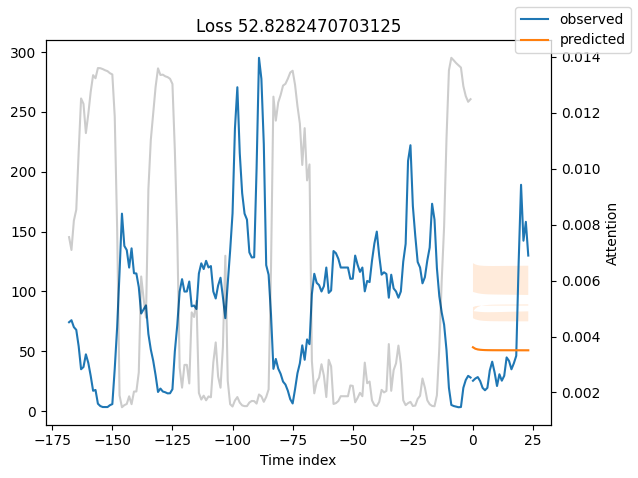

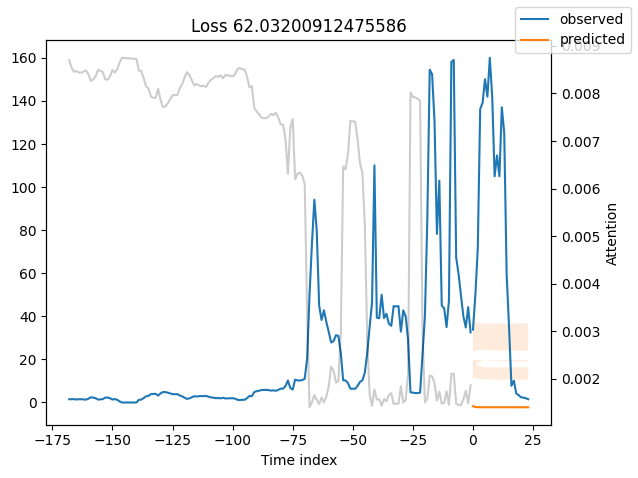

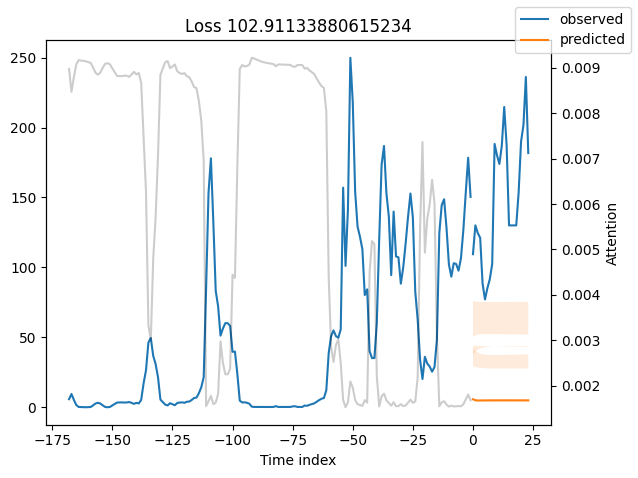

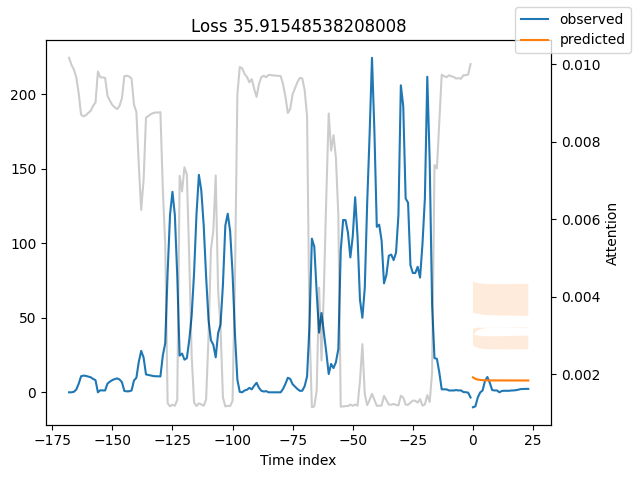

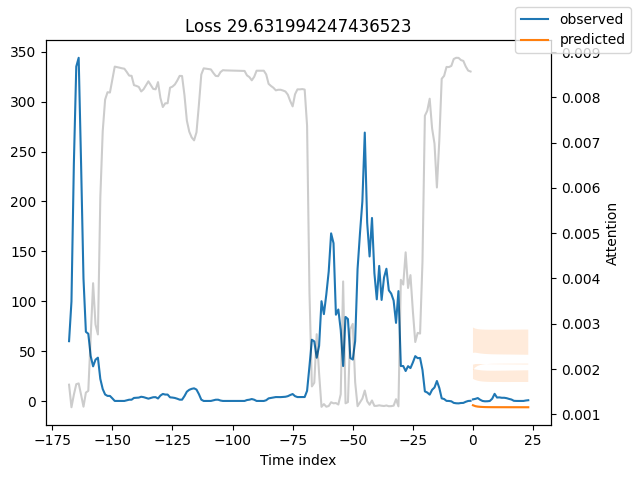

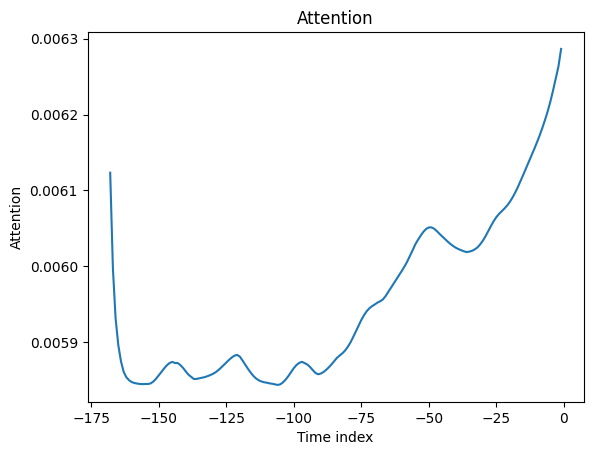

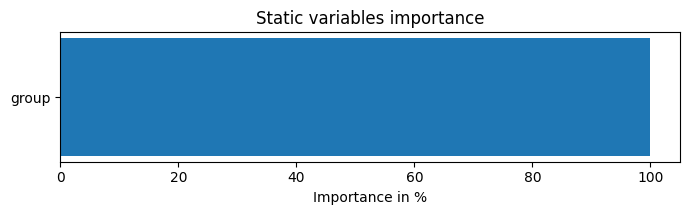

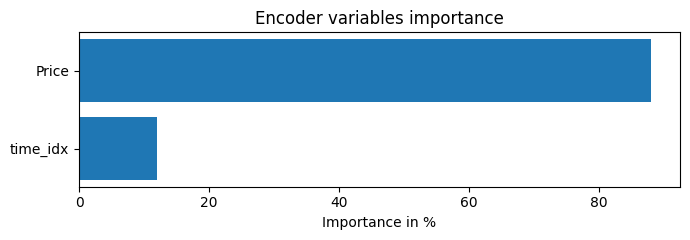

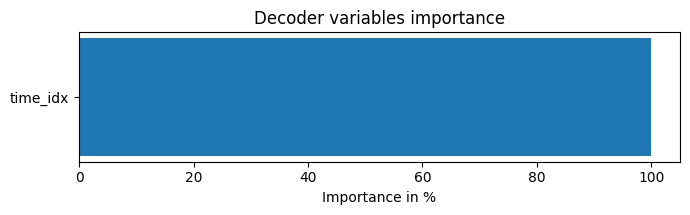

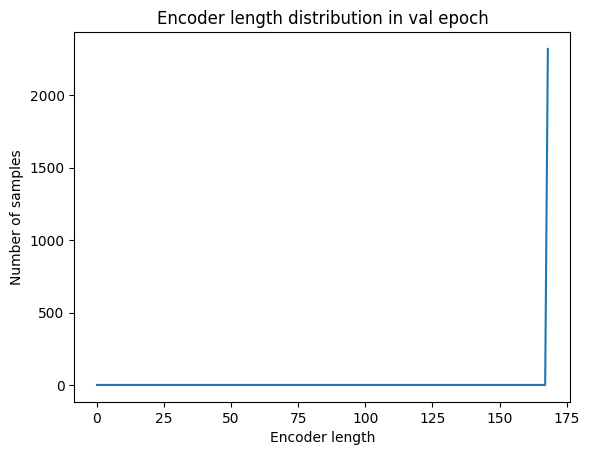

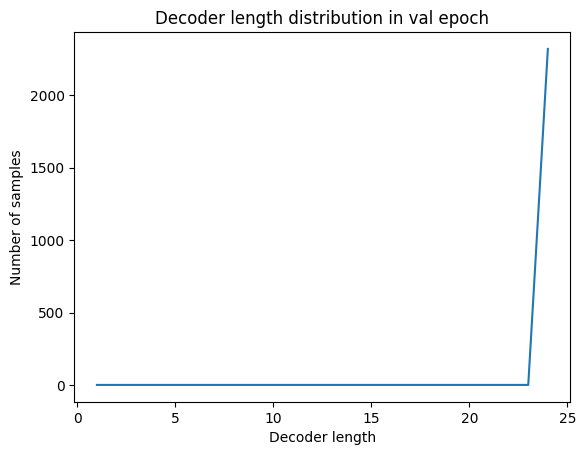

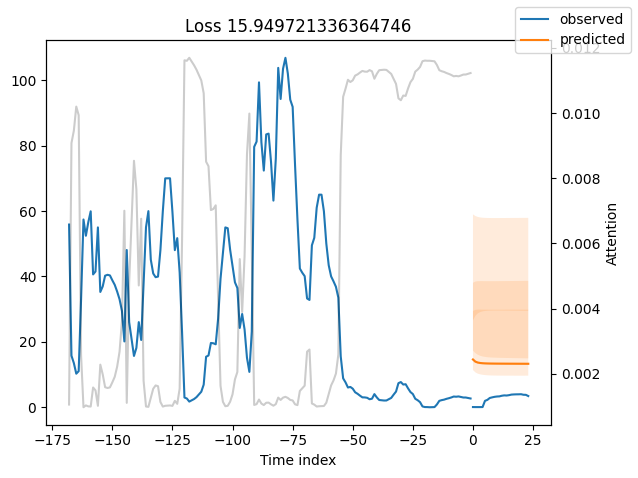

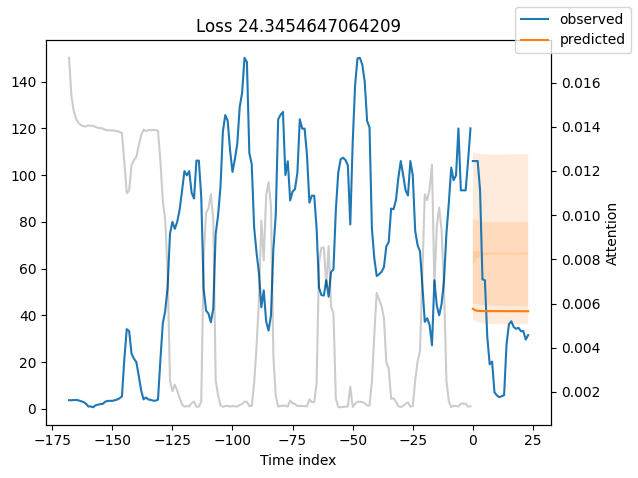

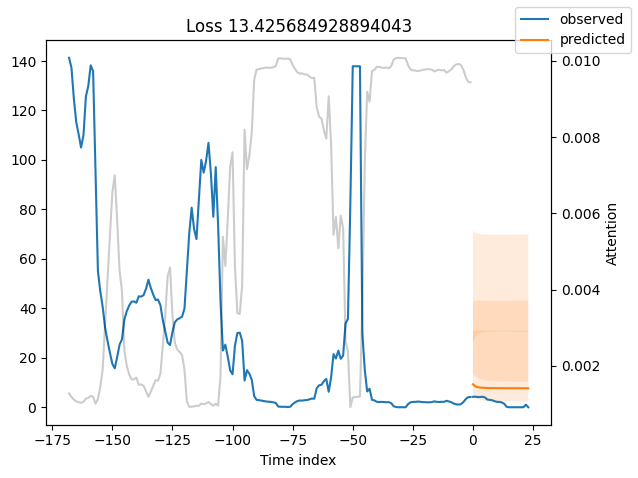

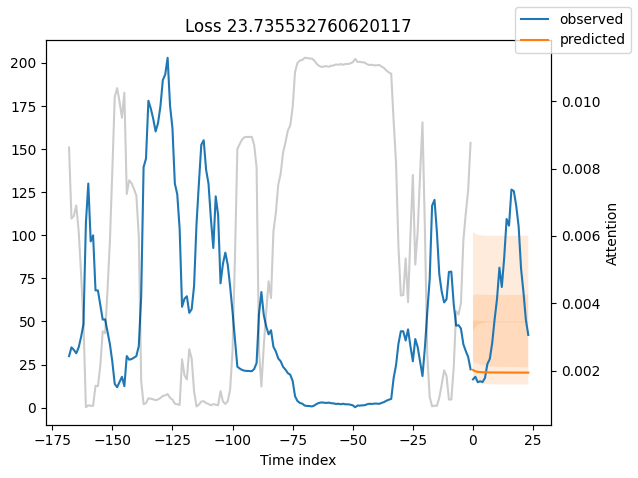

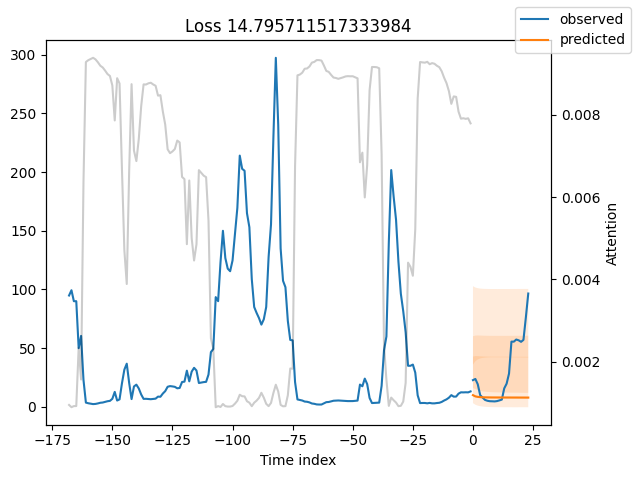

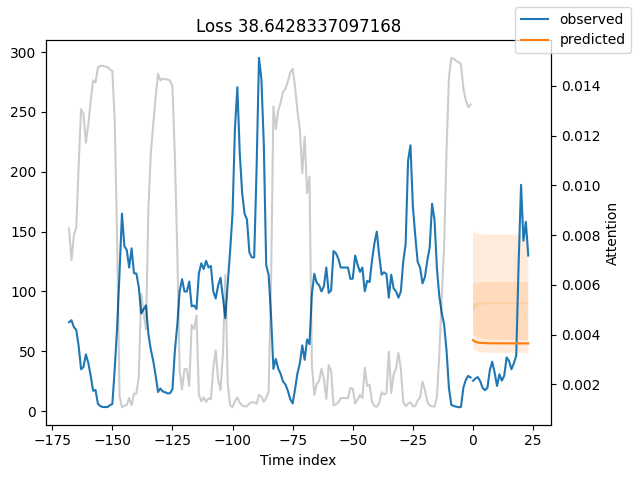

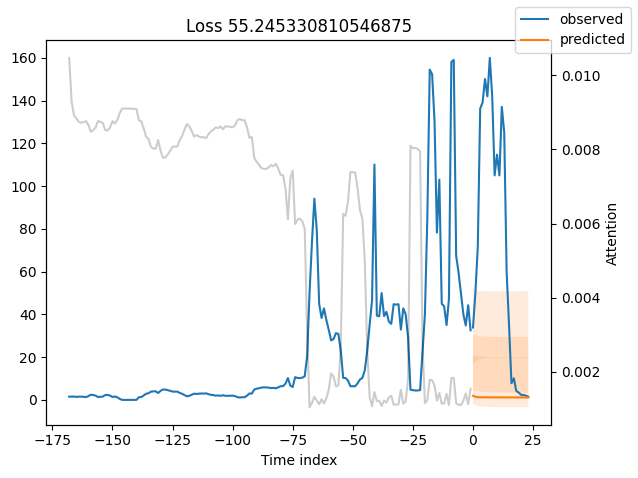

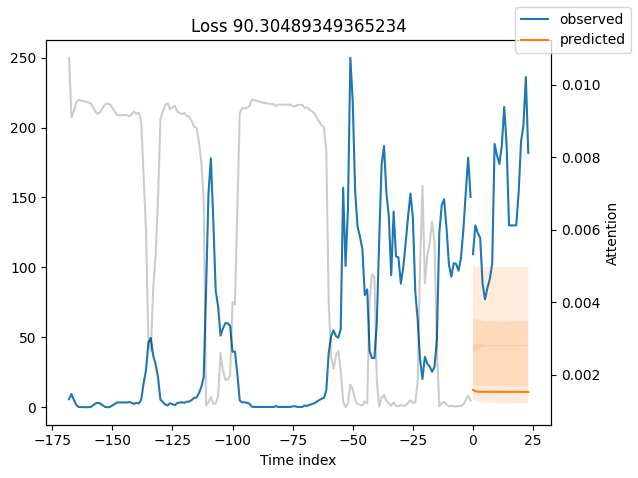

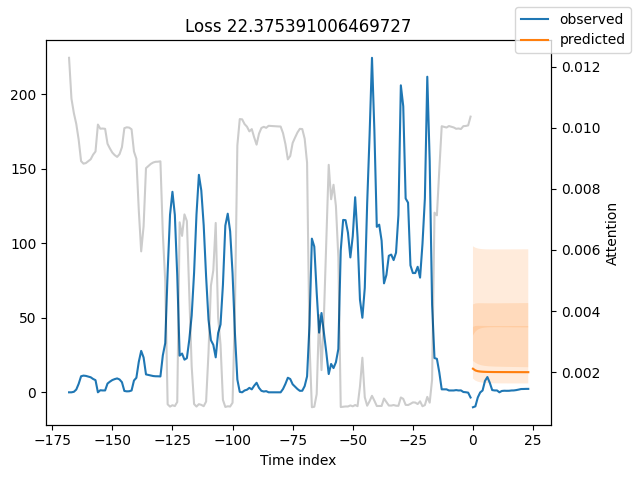

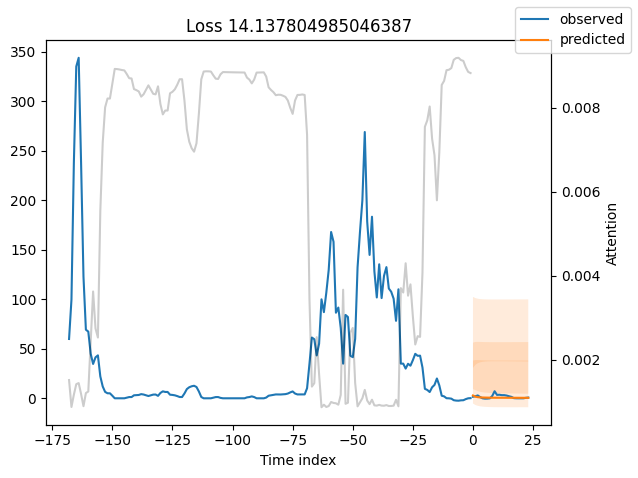

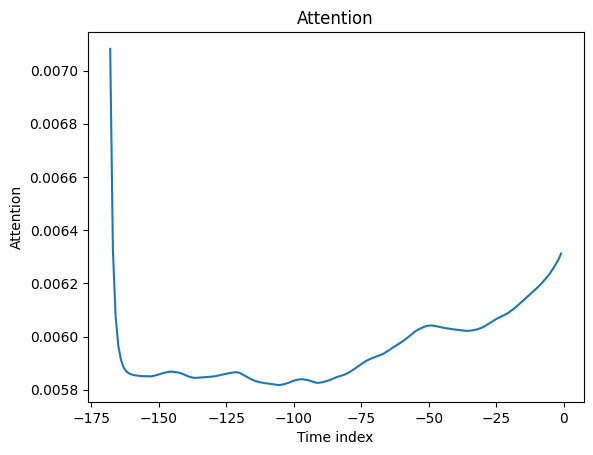

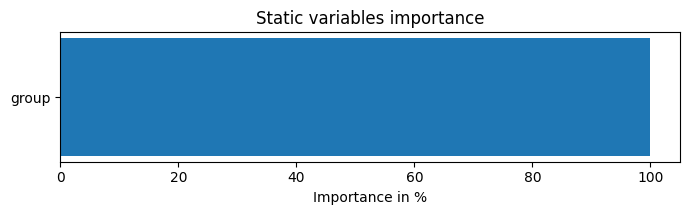

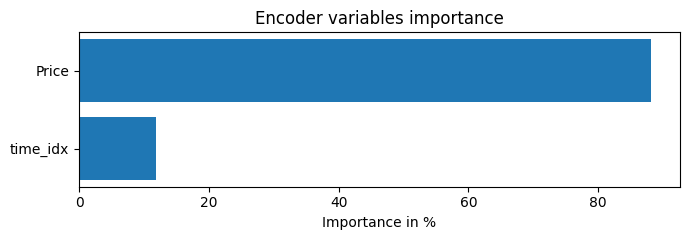

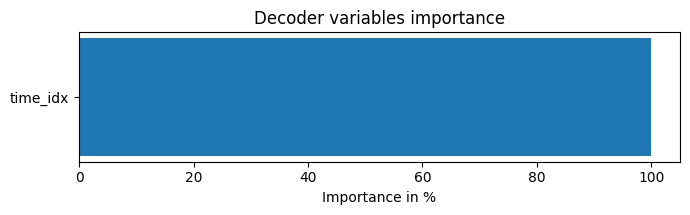

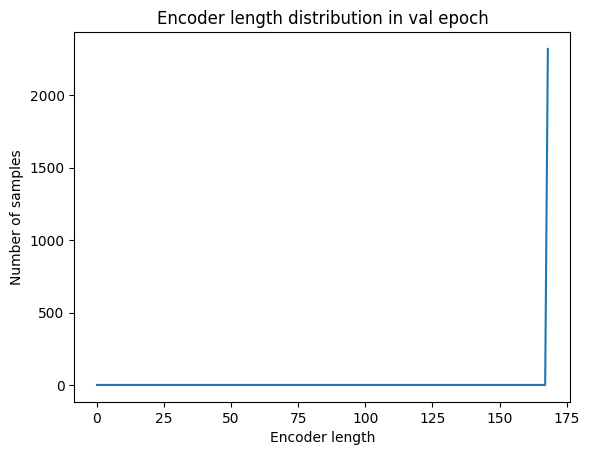

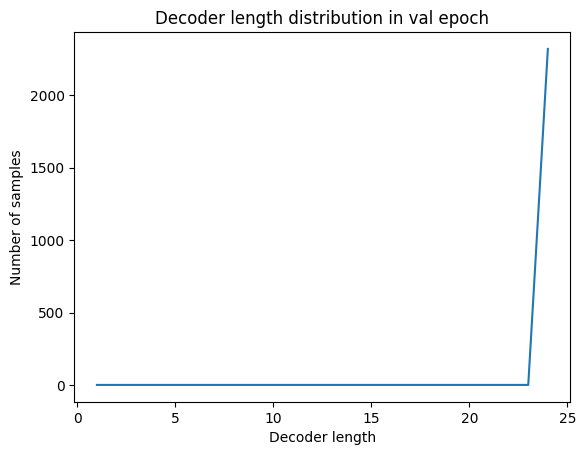

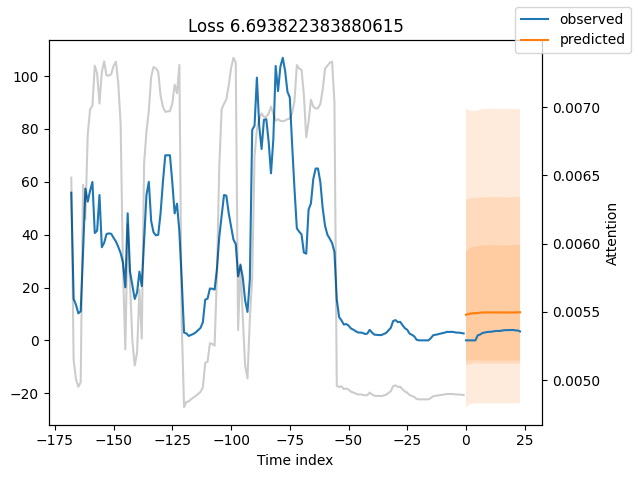

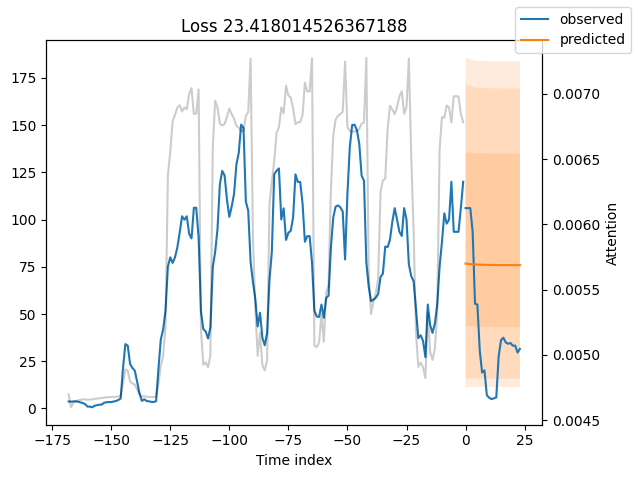

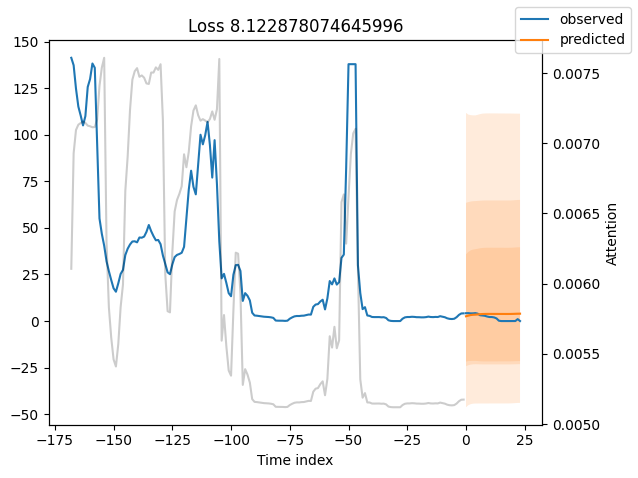

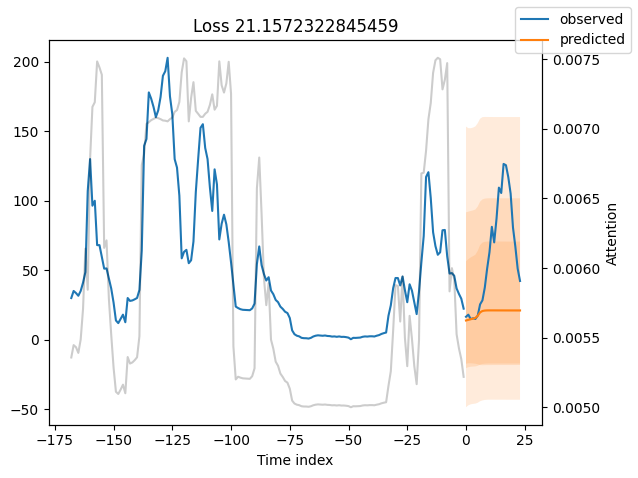

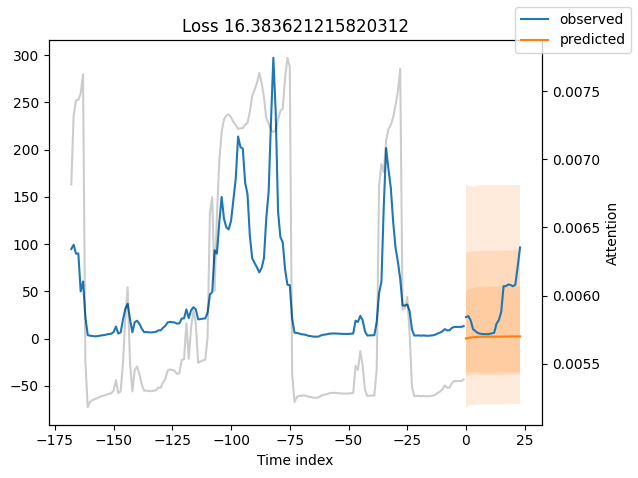

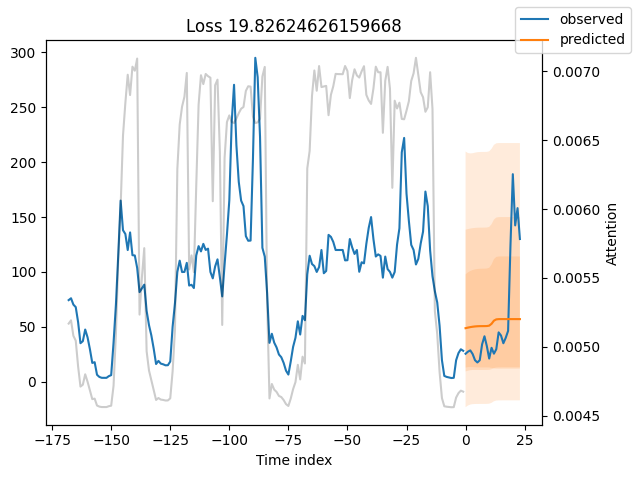

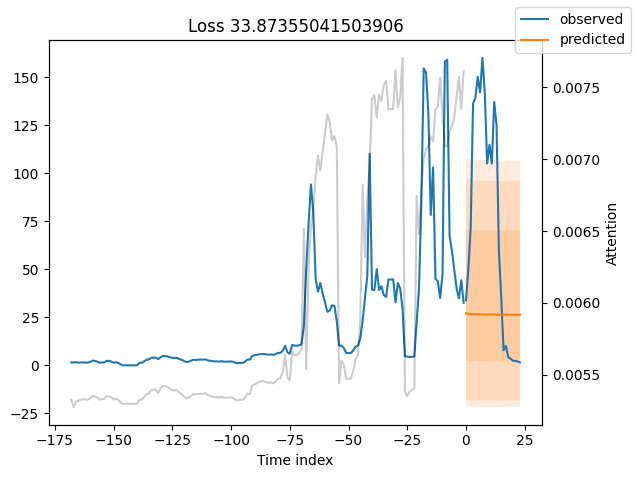

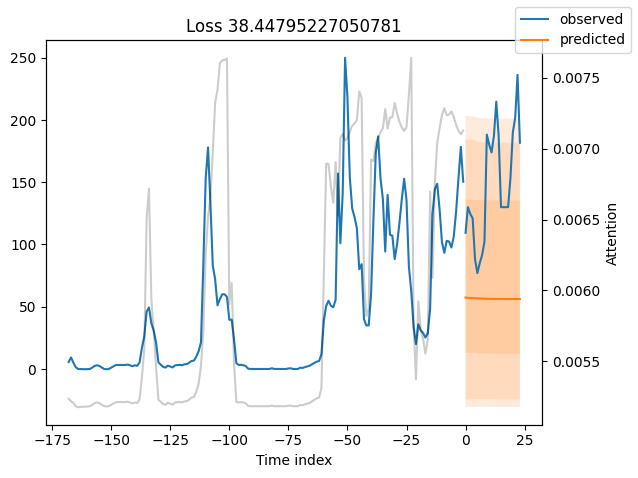

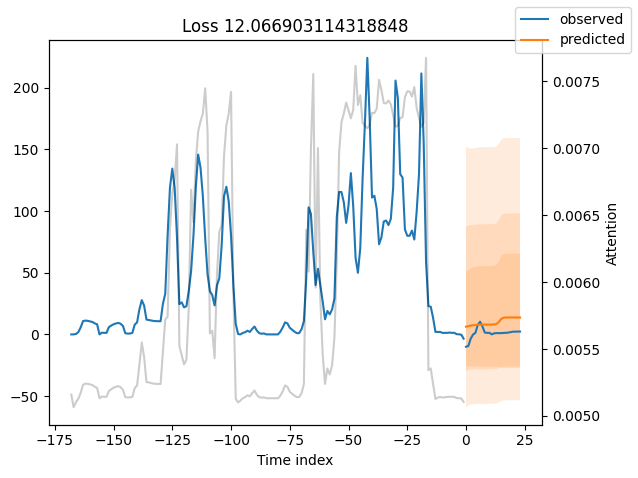

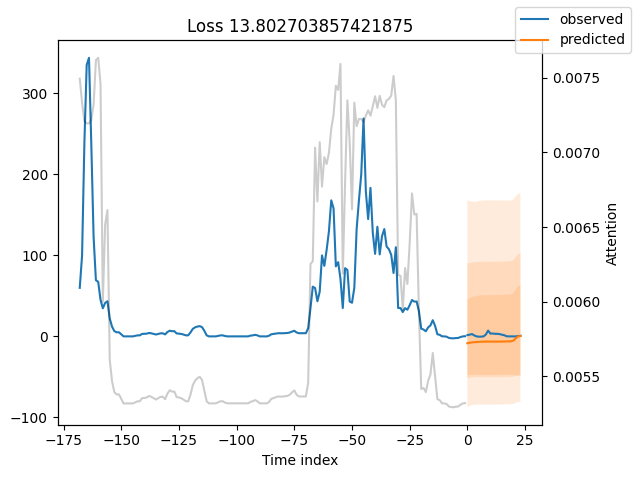

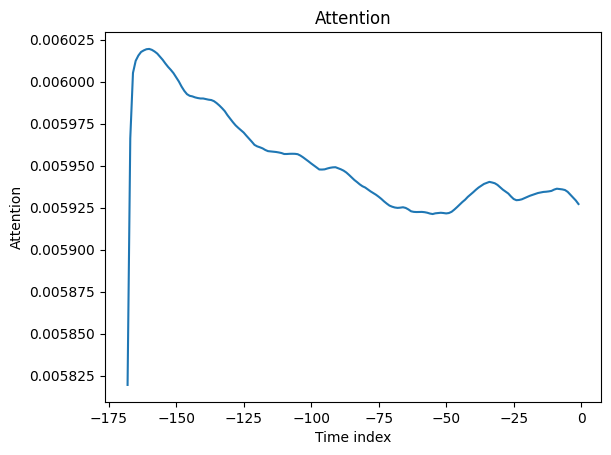

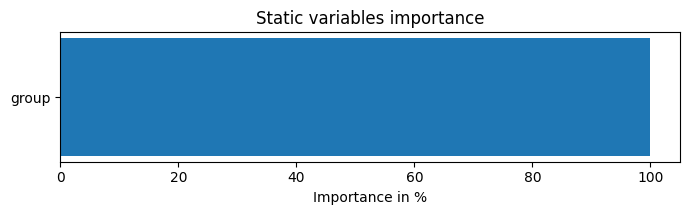

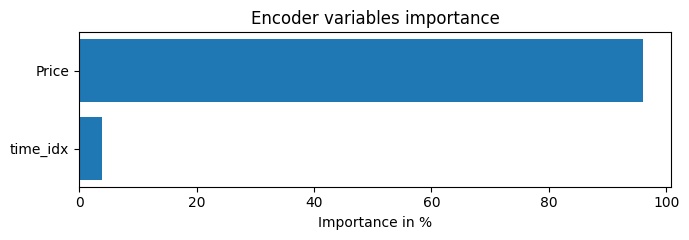

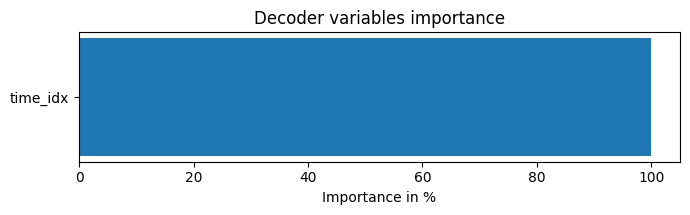

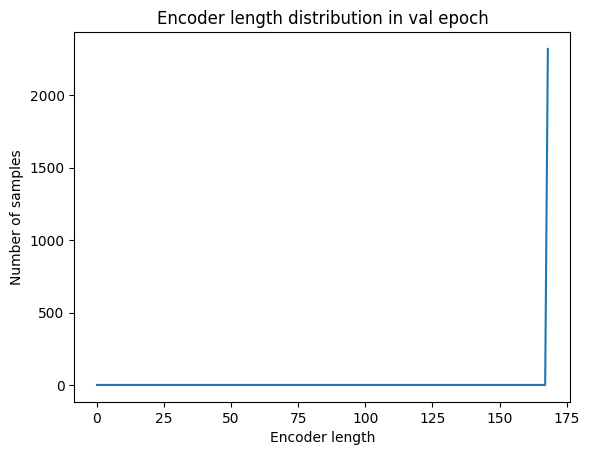

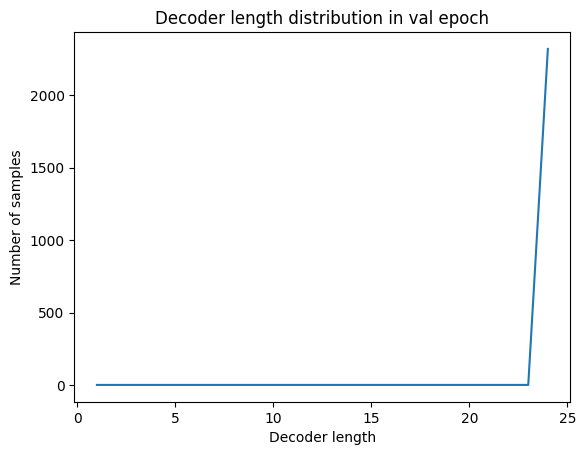

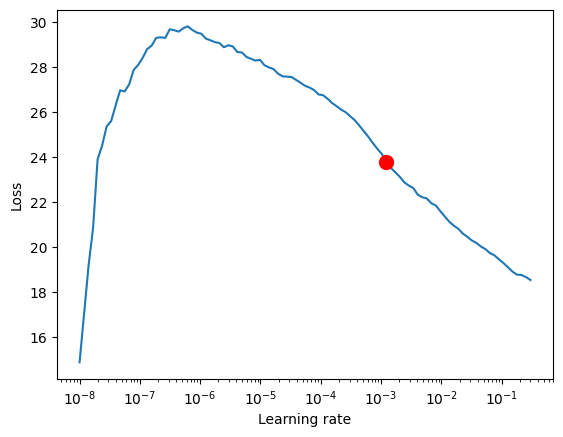

/var/folders/dm/2grrnq_n3yqf3njbkcck41pc0000gn/T/ipykernel_24614/726526489.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 64     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 96     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
7  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/ethanbareille/miniconda3/envs/ml_env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [40]:
# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.03,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

In [26]:
# Prédiction brute avec return_x
raw_output = tft.predict(val_dataloader, mode="raw", return_x=True)

# Explorer ce que contient l'objet
print(type(raw_output))
print(len(raw_output))


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'pytorch_forecasting.models.base_model.Prediction'>
5


In [32]:
# Afficher directement les prédictions depuis le modèle et le dataloader
tft.plot_prediction(val_dataloader, show_future_observed=True, idx=0)


TypeError: TemporalFusionTransformer.plot_prediction() missing 1 required positional argument: 'out'